# Testing bias metrics and mitigation algorithms on the Adult Income dataset

In [1]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OrdinalEncoder
from aif360.algorithms.preprocessing import Reweighing, DisparateImpactRemover
from utility import *
sns.set_theme(style='darkgrid')

In [2]:
def load_dataset():
    column_names = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 
                'occupation','relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income']
    adult_df = pd.read_csv('adult/adult.data', names=column_names)
    adult_df.drop(adult_df[(adult_df['race'] != ' Black') & (adult_df['race'] != ' White')].index,inplace=True)
    adult_df.loc[adult_df['native-country'] == ' ?', 'native-country'] = 'Not known'
    return adult_df

## Dataset description

The Adult Income dataset contains informations about the income of people extracted from the 1994 Census database. Prediction task is to determine whether a person makes over 50K a year. It has been shown that the dataset is bias in favor of white men and against women and people of other races.

## Dataset fairness metrics definition

The group fairness metrics related to the dataset are defined as follows:

- **Disparate impact**

$$
\frac{Pr(Y=1|S=unprivileged)}{Pr(Y=1|S=privileged)}
$$

> If the value is less than 0.8 or more than 1.2 we say that there is a _disparate impact_ on data

- **Statistical parity**

$$
Pr(Y=1|S=unprivileged)-Pr(Y=1|S=privileged)
$$

## Classifier fairness metrics definition

The group fairness metrics related to the classifier are defined below:

- **Balanced Accuracy**

$$
\frac{TP + TN}{2}
$$

- **Statistical parity**

$$
Pr(\hat{Y}=1|S=unprivileged)-Pr(\hat{Y}=1|S=privileged)
$$

- **Disparate Impact**

$$
\frac{Pr(\hat{Y}=1|S=unprivileged)}{Pr(\hat{Y}=1|S=privileged)}
$$

>If the value is less than 0.8 or more than 1.2 we say that there is a _disparate impact_ on data
- **Average odds difference**

$$
\frac{[(FPR_{S=unpriv} - FPR_{S=priv})+(TPR_{S=unpriv} - TPR_{S=priv})]}{2}
$$
>A value of 0 means _equality of odds_

- **Equal opportunity difference**

$$
TPR_{S=unpriv} - TPR_{S=priv}
$$

- **Theil Index**

$$
\frac{1}{n}\sum_{i=1}^n\frac{b_{i}}{\mu}\ln(\frac{b_{i}}{\mu}) \\
\text{with: } b_i=\hat{y_i}-y_i+1 \text{ and $\mu$ is the mean of $b_i$ }
$$
>Individual index measuring the distance of each individual predicted y from his real value. A value of 0 means equality. 

## Bias mitigation algorithms

In the following we will test two preprocessing bias mitigation algorithms and we will compare the impact they have on the model accuracy. The algorithms that we will test are the following:

1. **Reweighing**
    
> Reweighing is a preprocessing technique that Weights the examples in each (group, label) combination differently to ensure fairness before classification

2. **Disparate Impact Remover**

> This algorithm changes the values of the unsensitive variables at different levels of repair. An higher level of repair removes the disparate impact but loweres the accuracy, while a low level of repair does not change the data. The values of the unsensitive attributes are changed s.t. the correlation between the variables and the sensitive attribute _S_ is removed while keeping the ranking of the items for the classifier. In this way it is no more possible to predict the sensitive variable _S_ from the unsensitive attributes.
>
> Following the pre processing procedure suggested by M. Feldman et al. in _"Certifying and removing disparate impact." ACM SIGKDD International Conference on Knowledge Discovery and Data Mining, 2015_, we first scale the values s.t. the minimum is 0 and the maximum is 1 and then remove the sensitive variable from the dataset before training the classifier.
>
>**NB:** Categorical data must be transformed in ordered values

3. **Sampling**

> Sampling is a modified version of the Reweighing algorithm. First of all, it considered the groups made by each combinantion of the values of sensitive variables and labels. Then, for each group it computes his disparity ($\frac{size\_exp}{size\_obs}$) and samples each group untill this value becomes 1. The final dataset will be a dataset in which each group is balanced.

# Importing and exploring the dataset

In [3]:
adult_df = load_dataset()
adult_df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [4]:
adult_df.shape

(30940, 15)

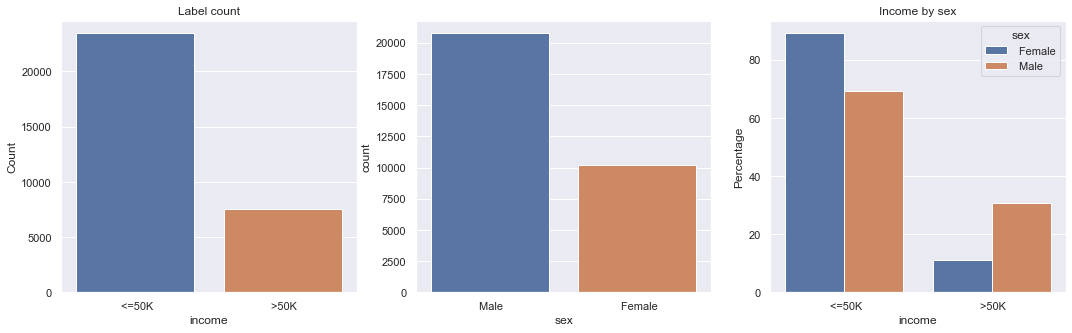

In [5]:
fig,ax = plt.subplots(1,3,figsize=(18,5))
sns.barplot(x='income', y='percentage', 
            data=adult_df[['sex','income']].groupby('sex')['income'].value_counts(normalize=True).rename('percentage').mul(100).reset_index(),
            hue='sex',
            ax=ax[2])
sns.countplot(x='income', data=adult_df, ax=ax[0])
sns.countplot(x='sex', data=adult_df, ax=ax[1])
ax[2].set(ylabel='Percentage', title="Income by sex")
ax[0].set(ylabel='Count', title="Label count")
plt.show()

So we are in an **Unbalanced Bias Dataset** case.

## Dataset transformation

In [6]:
lab_enc = LabelEncoder()
ord_enc = OrdinalEncoder()

In [7]:
adult_df['age_class'] = pd.cut(adult_df['age'],
                               bins=[0,9,19,29,39,49,59,69,99],
                               labels=['age<10','age between 10 and 20','age between 20 and 30',
                                       'age between 30 and 40','age between 40 and 50',
                                       'age between 50 and 60','age between 60 and 70','age>70']
                              )
adult_df['hour-per-week-class'] = pd.cut(adult_df['hours-per-week'],
                               bins=[0,9,19,29,39,49,99],
                               labels=['hour<10','hours between 10 and 20','hours between 20 and 30',
                                       'hours between 30 and 40','hour between 40 and 50',
                                       'hour>70']
                              )
adult_df.drop(labels=['hours-per-week','workclass','fnlwgt','capital-gain','capital-loss','age','education-num'],
              axis=1,inplace=True)
adult_df = adult_df.join(pd.get_dummies(adult_df['education'])).drop('education',axis=1)
adult_df = adult_df.join(pd.get_dummies(adult_df['marital-status'])).drop('marital-status',axis=1)
adult_df = adult_df.join(pd.get_dummies(adult_df['occupation'])).drop('occupation',axis=1)
adult_df = adult_df.join(pd.get_dummies(adult_df['relationship'])).drop('relationship',axis=1)
adult_df = adult_df.join(pd.get_dummies(adult_df['native-country'])).drop('native-country',axis=1)
adult_df = adult_df.join(pd.get_dummies(adult_df['age_class'])).drop('age_class',axis=1)
adult_df = adult_df.join(pd.get_dummies(adult_df['hour-per-week-class'])).drop('hour-per-week-class',axis=1)
adult_df['income'] = lab_enc.fit_transform(adult_df['income'])
adult_df[['sex','race']] = ord_enc.fit_transform(adult_df[['sex','race']])

# Bias dataset and classification metrics

Create a StructuredDataset object to which apply fairness metrics and methods

In [8]:
unprivileged_group = [{'sex': 0}]
privileged_group = [{'sex': 1}]

In [9]:
data = BinaryLabelDataset(
    favorable_label=1, unfavorable_label=0, df=adult_df, label_names=['income'], protected_attribute_names=['sex'])

### Dataset metrics

In [10]:
metrics = compute_dataset_fairness_metrics(data, unprivileged_group, privileged_group)

Disparate Impact = 0.3561
Statistical Parity = -0.1982


### Classification metrics

Balanced accuracy: 0.8118
Statistical parity difference: -0.3533
Disparate impact: 0.2857
Average odds difference: -0.2209
Equal opportunity difference: -0.1925
Theil index: 0.0826


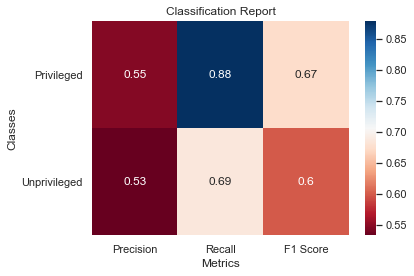

In [11]:
class_metrics = classify(
    make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced', solver='liblinear')), 
    data, privileged_group, unprivileged_group)

## Reweighing

In [12]:
rw_data = data.copy()
rw = Reweighing(unprivileged_group, privileged_group)
rw_data = rw.fit_transform(rw_data)

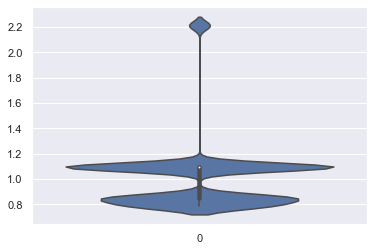

In [13]:
sns.violinplot(data=rw_data.instance_weights)
plt.show()

### Dataset metrics

In [14]:
metrics = compute_dataset_fairness_metrics(rw_data, unprivileged_group, privileged_group)

Disparate Impact = 1.0000
Statistical Parity = 0.0000


### Classificatiom metrics

Balanced accuracy: 0.7990
Statistical parity difference: -0.0649
Disparate impact: 0.8340
Average odds difference: -0.0340
Equal opportunity difference: 0.0258
Theil index: 0.0902


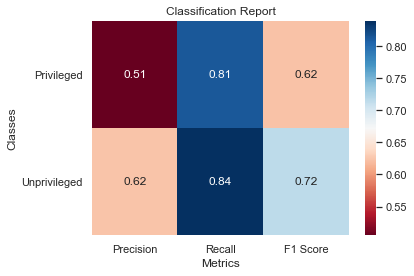

In [15]:
rw_class = classify(
    make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced', solver='liblinear')), 
    rw_data, privileged_group, unprivileged_group)

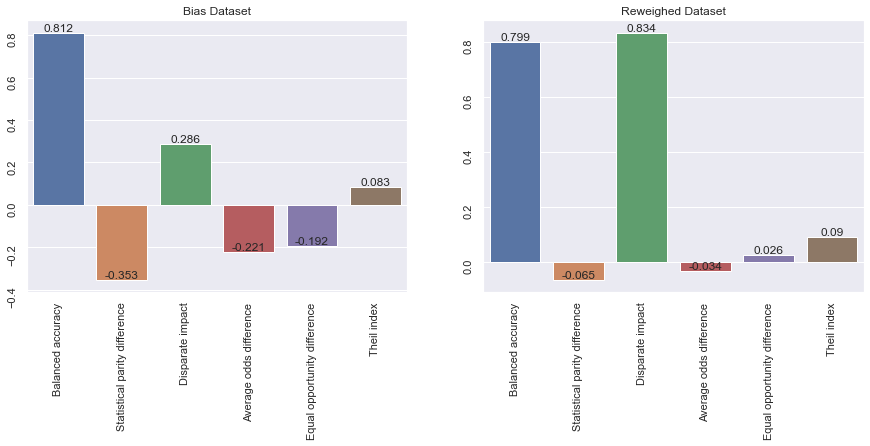

In [16]:
plot_metrics_comparison(class_metrics, rw_class, "Bias Dataset", "Reweighed Dataset")
plt.show()

## Disparate Impact Remover

First we will apply the DIR to the One Hot Encoded dataset and see if it has some effects on the bias mitigation

In [17]:
dir_data = data.copy()
scaler = MinMaxScaler(copy=False)
dir_data.features = scaler.fit_transform(dir_data.features)

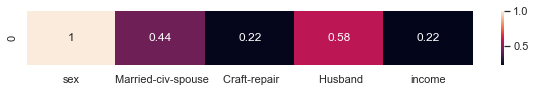

In [18]:
df = dir_data.convert_to_dataframe()[0]
corr = df.corrwith(df['sex'])
corr = pd.DataFrame(corr)
fig, ax = plt.subplots(1,1,figsize=(10,1))
sns.heatmap(corr[corr[0] > .2].T, ax=ax, annot=True)
plt.show()

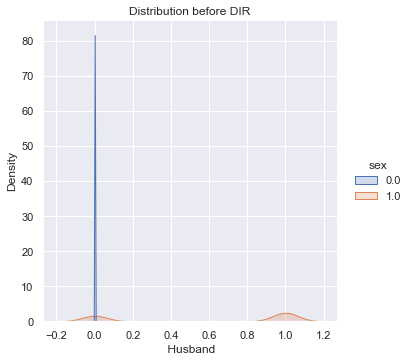

In [19]:
sns.displot(data=df, x=' Husband', hue='sex', kind='kde', multiple='layer', fill=True)
plt.title('Distribution before DIR')
plt.show()

Apply DIR and check correlation changes:

In [20]:
di = DisparateImpactRemover(sensitive_attribute='sex')
dir_data_trans = di.fit_transform(dir_data)

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


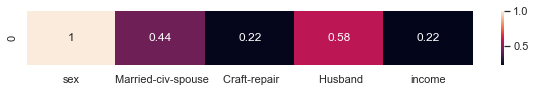

In [21]:
df = dir_data_trans.convert_to_dataframe()[0]
corr = df.corrwith(df['sex'])
corr = pd.DataFrame(corr)
fig, ax = plt.subplots(1,1,figsize=(10,1))
sns.heatmap(corr[corr[0] > .2].T, ax=ax, annot=True)
plt.show()

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


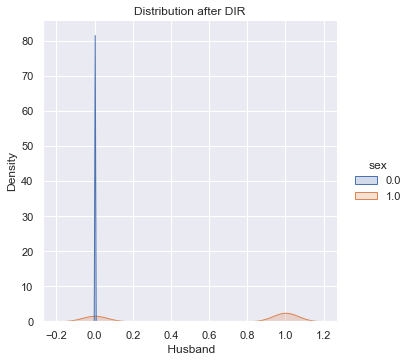

In [22]:
sns.displot(data=df, x=' Husband', hue='sex', kind='kde', multiple='layer', fill=True)
plt.title('Distribution after DIR')
plt.show()

### Dataset Metrics

In [23]:
metrics = compute_dataset_fairness_metrics(dir_data, unprivileged_group, privileged_group)

Disparate Impact = 0.3561
Statistical Parity = -0.1982


### Classification Metrics

Balanced accuracy: 0.8110
Statistical parity difference: -0.3164
Disparate impact: 0.3489
Average odds difference: -0.1683
Equal opportunity difference: -0.1196
Theil index: 0.0825


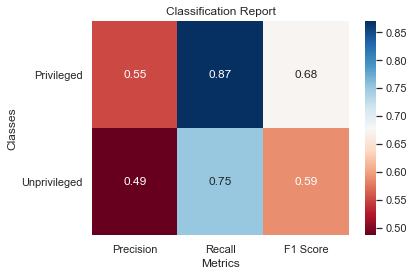

In [24]:
dir_class = classify(
    make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced', solver='liblinear')), 
    dir_data, privileged_group, unprivileged_group, sensitive_attributes=['sex'])

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


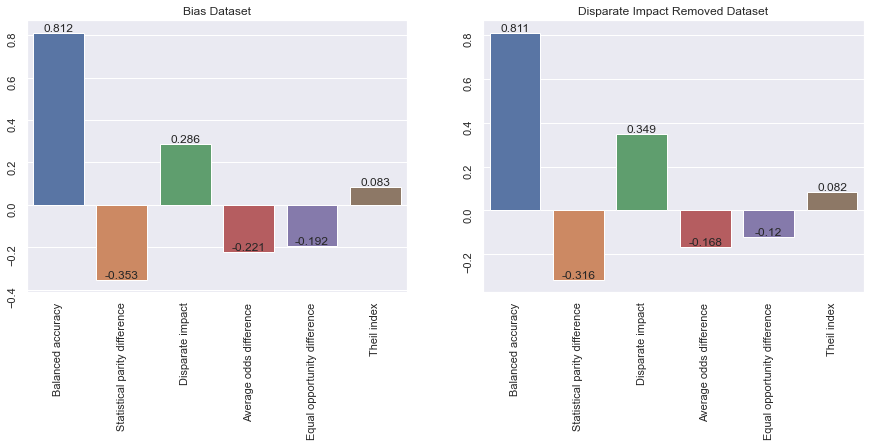

In [25]:
plot_metrics_comparison(class_metrics, dir_class, 'Bias Dataset', 'Disparate Impact Removed Dataset')
plt.show()

## Modified Reweighing (Sampling)

Original dataset size: (30940,102)
Sampled dataset size: (30940,102)


Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


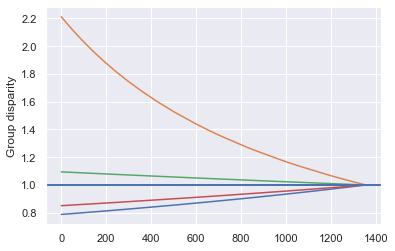

In [26]:
sampled_data = sample_dataset(
    adult_df, 
    [adult_df['sex']==1, adult_df['sex']==0], 
    adult_df['income']==1,
    adult_df['income']==0,
    ['sex'], 'income', 4)
plt.show()

### Dataset Metrics

In [27]:
metrics = compute_dataset_fairness_metrics(sampled_data, unprivileged_group, privileged_group)

Disparate Impact = 0.9999
Statistical Parity = -0.0000


### Classification Metrics

Balanced accuracy: 0.8010
Statistical parity difference: -0.0612
Disparate impact: 0.8435
Average odds difference: -0.0271
Equal opportunity difference: 0.0389
Theil index: 0.0888


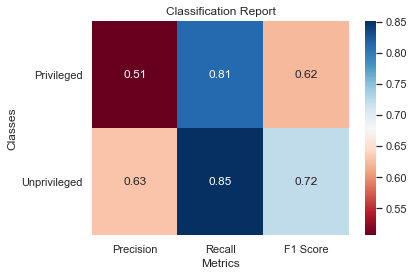

In [28]:
sampled_metrics = classify(
    make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced', solver='liblinear')), 
    sampled_data, privileged_group, unprivileged_group)

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


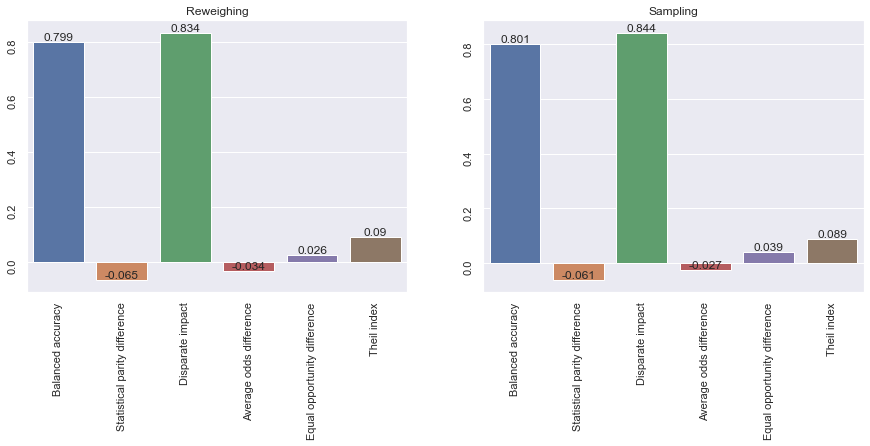

In [29]:
plot_metrics_comparison(rw_class, sampled_metrics, 'Reweighing', 'Sampling')
plt.show()

In [30]:
rw_class

{'Balanced accuracy': 0.799,
 'Statistical parity difference': -0.0649,
 'Disparate impact': 0.834,
 'Average odds difference': -0.034,
 'Equal opportunity difference': 0.0258,
 'Theil index': 0.0902}

In [31]:
sampled_metrics

{'Balanced accuracy': 0.801,
 'Statistical parity difference': -0.0612,
 'Disparate impact': 0.8435,
 'Average odds difference': -0.0271,
 'Equal opportunity difference': 0.0389,
 'Theil index': 0.0888}

## Reweighing vs DIR vs Sampling

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


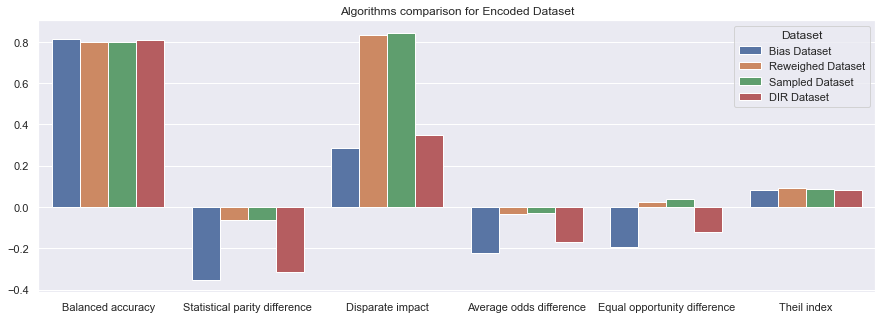

In [32]:
plot_syntesis(merge_datasets({
    'Bias Dataset': class_metrics,
    'Reweighed Dataset': rw_class,
    'Sampled Dataset': sampled_metrics,
    'DIR Dataset': dir_class,
}), "Algorithms comparison for Encoded Dataset")
plt.show()

# Test with numerical data

In [33]:
df = load_dataset()
drop_cols = ['workclass', 'fnlwgt', 'education', 
             'marital-status', 'occupation', 'relationship', 'native-country','race']
df.drop(df[drop_cols], axis=1, inplace=True)
le = LabelEncoder()
df['sex'] = le.fit_transform(df['sex'])
df['income'] = le.fit_transform(df['income'])
df

,age,education-num,sex,capital-gain,capital-loss,hours-per-week,income
0,39,13,1,2174,0,40,0
1,50,13,1,0,0,13,0
2,38,9,1,0,0,40,0
3,53,7,1,0,0,40,0
4,28,13,0,0,0,40,0
...,...,...,...,...,...,...,...
32556,27,12,0,0,0,38,0
32557,40,9,1,0,0,40,1
32558,58,9,0,0,0,40,0
32559,22,9,1,0,0,20,0


In [34]:
df_bin = BinaryLabelDataset(
    favorable_label=1, unfavorable_label=0, df=df, label_names=['income'], protected_attribute_names=['sex'])

In [35]:
metrics = compute_dataset_fairness_metrics(df_bin, unprivileged_group, privileged_group)

Disparate Impact = 0.3561
Statistical Parity = -0.1982


Balanced accuracy: 0.7616
Statistical parity difference: -0.3601
Disparate impact: 0.2366
Average odds difference: -0.3097
Equal opportunity difference: -0.3667
Theil index: 0.1091


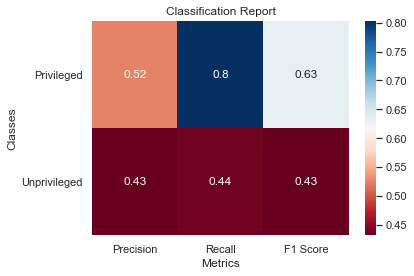

In [36]:
df_ord_class = classify(make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced', solver='liblinear')),
                        df_bin, privileged_group, unprivileged_group)

## Reweighing

In [37]:
rw = Reweighing(unprivileged_group, privileged_group)
df_bin_rw = df_bin.copy()
df_bin_rw = rw.fit_transform(df_bin)

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


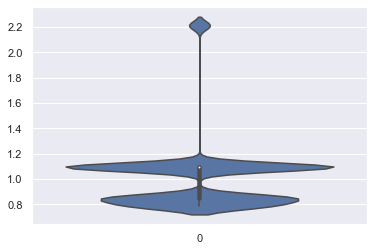

In [38]:
sns.violinplot(data=df_bin_rw.instance_weights)
plt.show()

In [39]:
metrics = compute_dataset_fairness_metrics(df_bin_rw, unprivileged_group, privileged_group)

Disparate Impact = 1.0000
Statistical Parity = 0.0000


Balanced accuracy: 0.7345
Statistical parity difference: 0.0014
Disparate impact: 1.0041
Average odds difference: -0.0068
Equal opportunity difference: -0.0239
Theil index: 0.1209


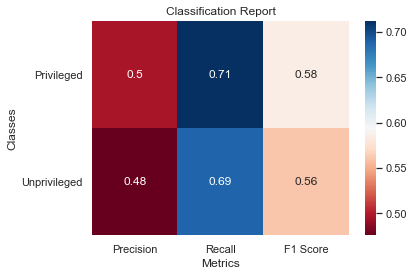

In [40]:
rw_ord_class = classify(
    make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced', solver='liblinear')), 
    df_bin_rw, privileged_group, unprivileged_group)

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


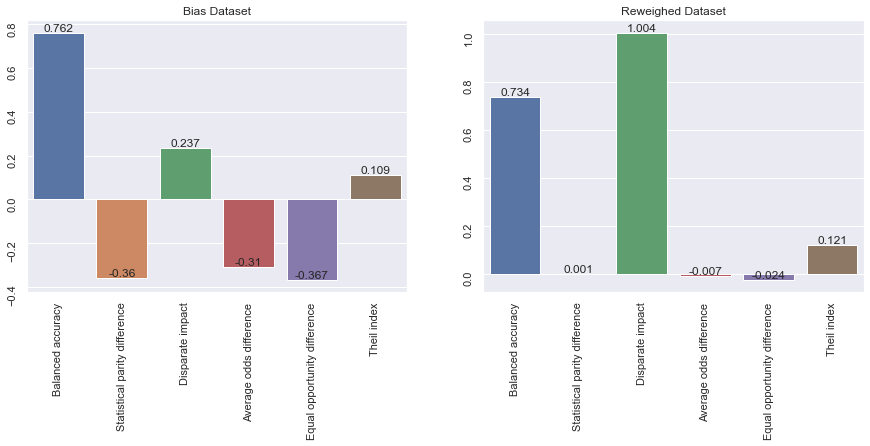

In [41]:
plot_metrics_comparison(df_ord_class, rw_ord_class, 'Bias Dataset', 'Reweighed Dataset')
plt.show()

## DIR

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


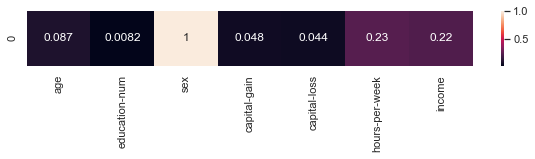

In [42]:
corr = df.corrwith(df['sex'])
corr = pd.DataFrame(corr)
fig, ax = plt.subplots(1,1,figsize=(10,1))
sns.heatmap(corr.T, annot=True)
plt.show()

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


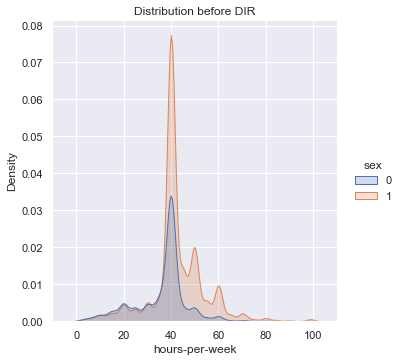

In [43]:
sns.displot(data=df, x='hours-per-week', hue='sex', kind='kde', multiple='layer', fill=True)
plt.title('Distribution before DIR')
plt.show()

In [44]:
df_dir = df_bin.copy()
scaler = MinMaxScaler(copy=False)
df_dir.features = scaler.fit_transform(df_bin.features)

In [45]:
di = DisparateImpactRemover(sensitive_attribute='sex')
df_dir = di.fit_transform(df_bin)

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


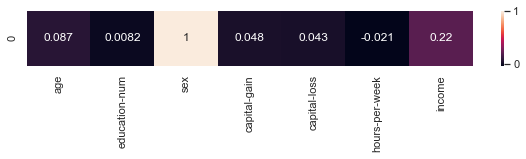

In [46]:
df = df_dir.convert_to_dataframe()[0]
corr = df.corrwith(df['sex'])
corr = pd.DataFrame(corr)
fig, ax = plt.subplots(1,1,figsize=(10,1))
sns.heatmap(corr.T, annot=True)
plt.show()

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


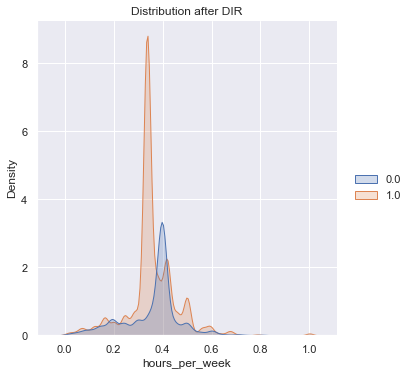

In [47]:
ax = sns.displot(x=df_dir.features[:,5], hue=df_dir.features[:,2], kind='kde', multiple='layer', fill=True)
plt.title('Distribution after DIR')
ax.set(xlabel='hours_per_week')
plt.show()

Balanced accuracy: 0.7320
Statistical parity difference: -0.0641
Disparate impact: 0.8301
Average odds difference: 0.0150
Equal opportunity difference: -0.0052
Theil index: 0.1227


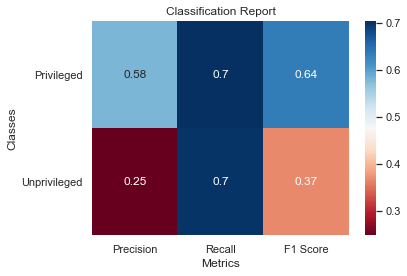

In [48]:
dir_ord_class = classify(make_pipeline(
    StandardScaler(), LogisticRegression(class_weight='balanced', solver='liblinear')), 
                         df_dir, privileged_group, unprivileged_group, sensitive_attributes=['sex'])

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


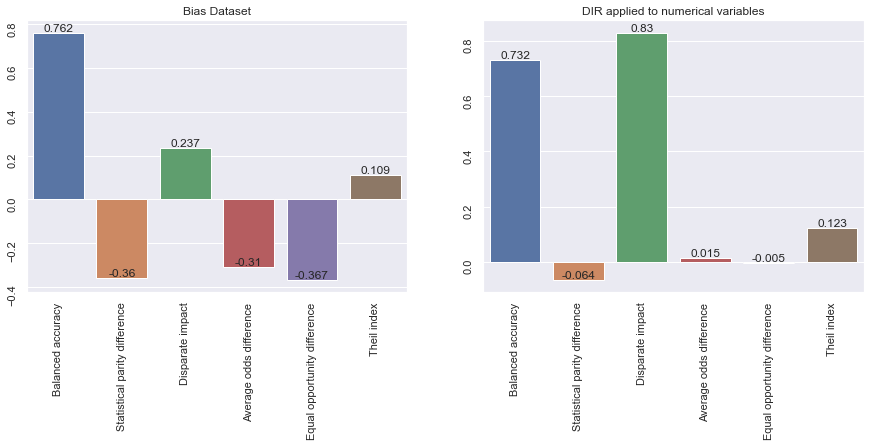

In [49]:
plot_metrics_comparison(df_ord_class, dir_ord_class, 'Bias Dataset', 'DIR applied to numerical variables')
plt.show()

## Modified Reweighing (Sampling)

Original dataset size: (30940,7)
Sampled dataset size: (30940,7)


Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


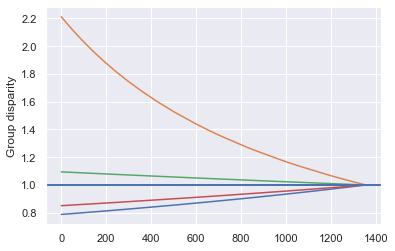

In [50]:
sampled_num = sample_dataset(
    df,
    [df['sex']==1, df['sex']==0], 
    df['income']==1,
    df['income']==0, 
    ['sex'], 'income',
    4)
plt.show()

In [51]:
metrics = compute_dataset_fairness_metrics(sampled_num, unprivileged_group, privileged_group)

Disparate Impact = 0.9999
Statistical Parity = -0.0000


Balanced accuracy: 0.7354
Statistical parity difference: 0.0019
Disparate impact: 1.0066
Average odds difference: -0.0054
Equal opportunity difference: -0.0196
Theil index: 0.1214


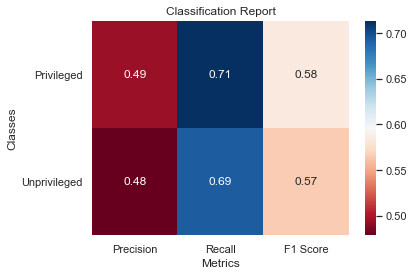

In [52]:
sampled_num_metrics = classify(
    make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced', solver='liblinear')),
    sampled_num, privileged_group, unprivileged_group)

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


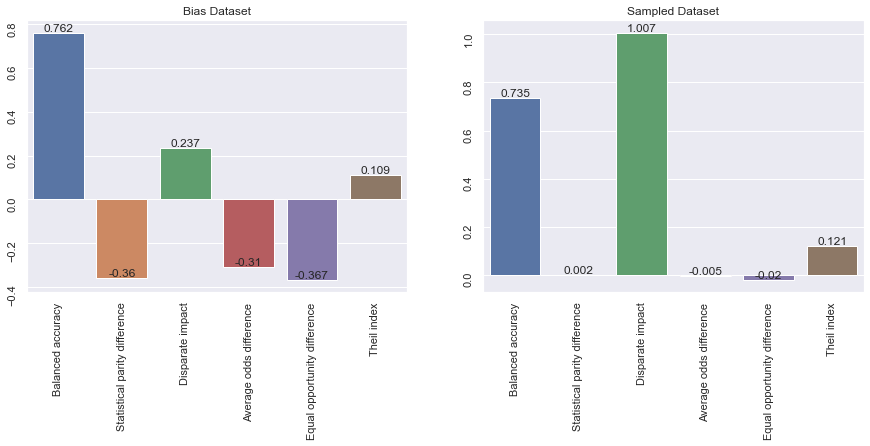

In [53]:
plot_metrics_comparison(df_ord_class, sampled_num_metrics, 'Bias Dataset', 'Sampled Dataset')
plt.show()

## Reweighing vs DIR vs Sampling

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


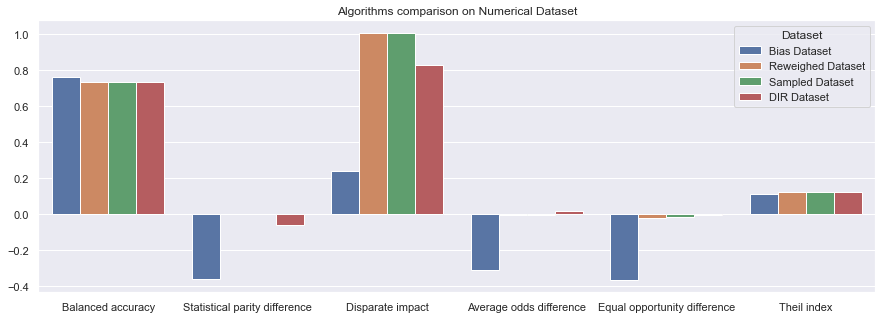

In [54]:
plot_syntesis(merge_datasets({
    'Bias Dataset': df_ord_class,
    'Reweighed Dataset': rw_ord_class,
    'Sampled Dataset': sampled_num_metrics,
    'DIR Dataset': dir_ord_class,
}), 'Algorithms comparison on Numerical Dataset')
plt.show()

# Reweighing + DIR

## Dataset with One Hot Encoded attributes

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


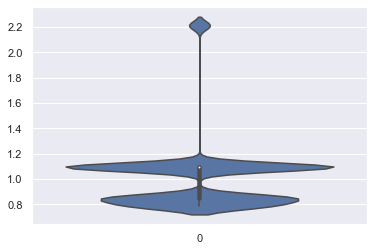

In [55]:
rw_dir_enc = dir_data.copy()
rw = Reweighing(unprivileged_group, privileged_group)
rw_dir_enc = rw.fit_transform(rw_dir_enc)
sns.violinplot(data=rw_dir_enc.instance_weights)
plt.show()

In [56]:
metrics = compute_dataset_fairness_metrics(rw_dir_enc, unprivileged_group, privileged_group)

Disparate Impact = 1.0000
Statistical Parity = 0.0000


Balanced accuracy: 0.8001
Statistical parity difference: -0.0880
Disparate impact: 0.7787
Average odds difference: -0.0565
Equal opportunity difference: 0.0045
Theil index: 0.0886


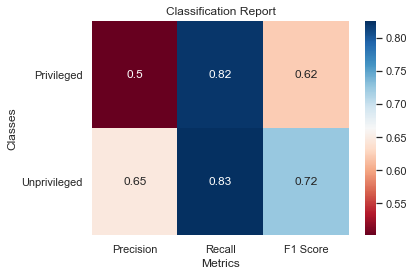

In [57]:
rw_dir_enc_score = classify(
    make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced', solver='liblinear')),
    rw_dir_enc, privileged_group, unprivileged_group, sensitive_attributes=['sex'])

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


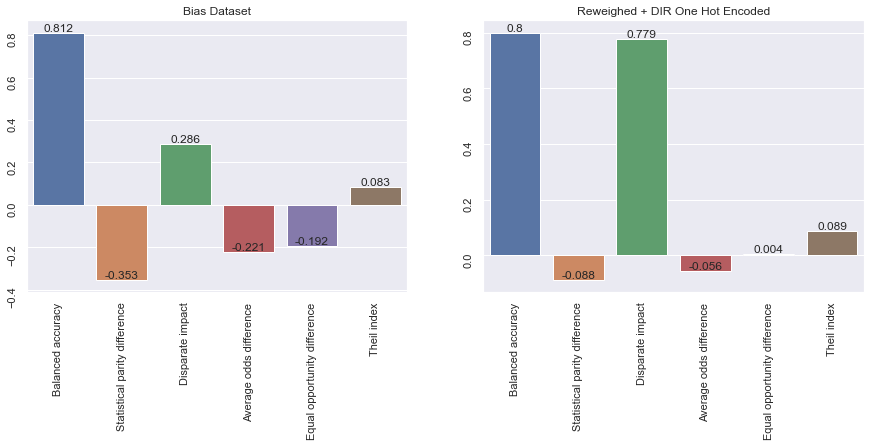

In [58]:
plot_metrics_comparison(class_metrics, rw_dir_enc_score, 'Bias Dataset', 'Reweighed + DIR One Hot Encoded')
plt.show()

## Dataset with numerical attributes

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


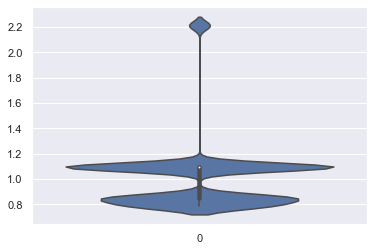

In [59]:
rw_dir_data = df_dir.copy()
rw = Reweighing(unprivileged_group, privileged_group)
rw_dir_data = rw.fit_transform(rw_dir_data)
sns.violinplot(data= rw_dir_data.instance_weights)
plt.show()

In [60]:
metrics = compute_dataset_fairness_metrics(rw_dir_data, unprivileged_group, privileged_group)

Disparate Impact = 1.0000
Statistical Parity = 0.0000


Balanced accuracy: 0.7332
Statistical parity difference: 0.0314
Disparate impact: 1.0930
Average odds difference: 0.0249
Equal opportunity difference: 0.0091
Theil index: 0.1231


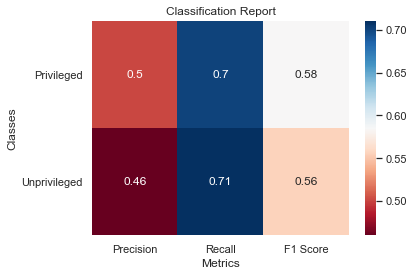

In [61]:
rw_dir_score = classify(
    make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced', solver='liblinear')), 
    rw_dir_data, privileged_group, unprivileged_group, sensitive_attributes=['sex'])

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


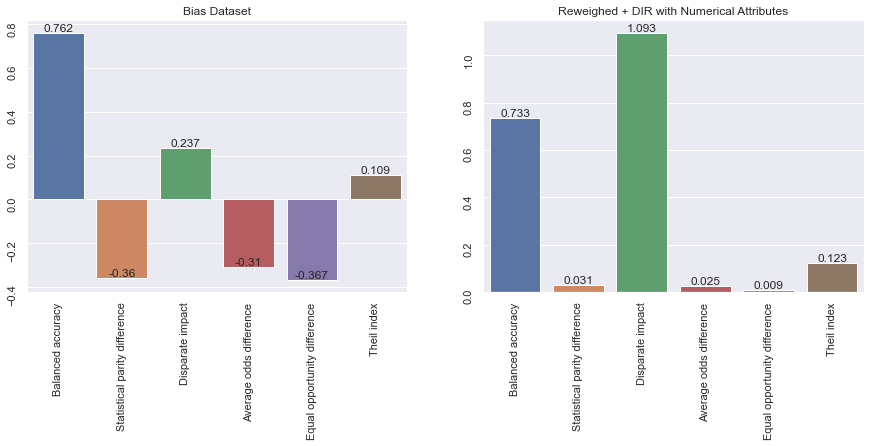

In [62]:
plot_metrics_comparison(df_ord_class, rw_dir_score, 'Bias Dataset', 'Reweighed + DIR with Numerical Attributes')
plt.show()

# Algorithms Comparison

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


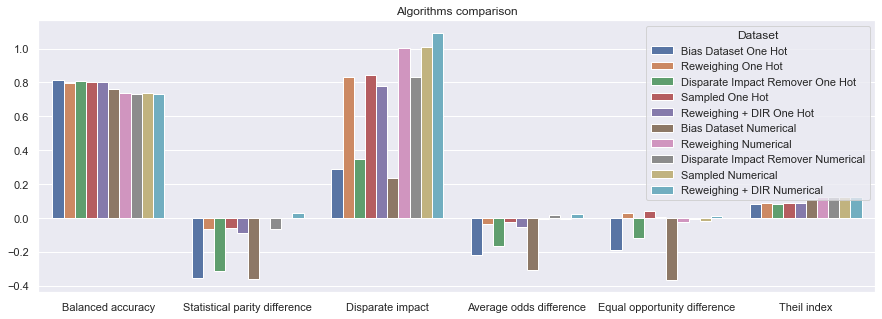

In [63]:
plot_syntesis(merge_datasets({
    'Bias Dataset One Hot': class_metrics,
    'Reweighing One Hot': rw_class,
    'Disparate Impact Remover One Hot': dir_class,
    'Sampled One Hot': sampled_metrics,
    'Reweighing + DIR One Hot': rw_dir_enc_score,
    'Bias Dataset Numerical': df_ord_class,
    'Reweighing Numerical': rw_ord_class,
    'Disparate Impact Remover Numerical': dir_ord_class,
    'Sampled Numerical': sampled_num_metrics,
    'Reweighing + DIR Numerical': rw_dir_score
}), 'Algorithms comparison')
plt.show()

# Test Adult with multiple sensitive attributes

In [64]:
df_2 = load_dataset()
drop_cols = ['workclass', 'fnlwgt', 'education', 
             'marital-status', 'occupation', 'relationship', 'native-country']
df_2.drop(df_2[drop_cols], axis=1, inplace=True)
le = LabelEncoder()
df_2['sex'] = le.fit_transform(df['sex'])
df_2['race'] = le.fit_transform(df_2['race'])

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


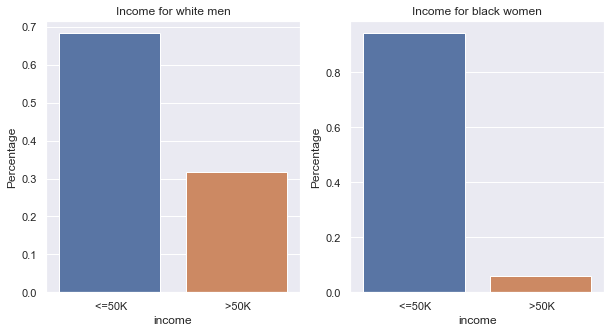

In [65]:
perc = (df_2[['sex','race','income']]
            .groupby(['sex','race'])['income']
            .value_counts(normalize=True)
            .rename('Percentage')
            .reset_index())
fig, [ax1, ax2] = plt.subplots(1,2, figsize=(10,5))
sns.barplot(data=perc[(perc['sex']==1)&(perc['race']==1)], x='income', y='Percentage', ax=ax1)
sns.barplot(data=perc[(perc['sex']==0)&(perc['race']==0)], x='income', y='Percentage', ax=ax2)
ax1.set_title('Income for white men')
ax2.set_title('Income for black women')
plt.show()

In [66]:
df_2[(df_2['sex']==0)&(df_2['race']==0)].shape

(1555, 8)

In [67]:
df_2[(df_2['sex']==1)&(df_2['race']==1)].shape

(19174, 8)

In [68]:
df_2['income'] = le.fit_transform(df_2['income'])

In [69]:
privileged_group = [{'sex': 1, 'race': 1}]
unprivileged_group = [{'sex': 0, 'race': 0}]

## Test on bias dataset

In [70]:
df_2bin = BinaryLabelDataset(df=df_2, protected_attribute_names = ['sex', 'race'], label_names=['income'])

### Dataset metrics

In [71]:
metrics = compute_dataset_fairness_metrics(df_2bin, unprivileged_group, privileged_group)

Disparate Impact = 0.1823
Statistical Parity = -0.2597


### Classification metrics

invalid value encountered in double_scalars


Balanced accuracy: 0.7618
Statistical parity difference: -0.4537
Disparate impact: 0.0868
Average odds difference: -0.3864
Equal opportunity difference: -0.4488
Theil index: 0.1085


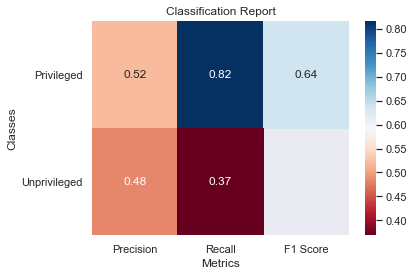

In [72]:
df2_class = classify(
    make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced', solver='liblinear')),
    df_2bin, privileged_group, unprivileged_group)

## Reweighing

In [73]:
rw = Reweighing(unprivileged_group, privileged_group)
df2_rw = rw.fit_transform(df_2bin.copy())

In [74]:
metrics = compute_dataset_fairness_metrics(df2_rw, unprivileged_group, privileged_group)

Disparate Impact = 1.0000
Statistical Parity = 0.0000


Balanced accuracy: 0.7407
Statistical parity difference: -0.1372
Disparate impact: 0.5974
Average odds difference: -0.1219
Equal opportunity difference: -0.1172
Theil index: 0.1226


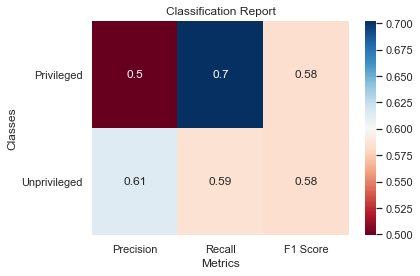

In [75]:
rw_df2_class = classify(
    make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced', solver='liblinear')),
    df2_rw, privileged_group, unprivileged_group)

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


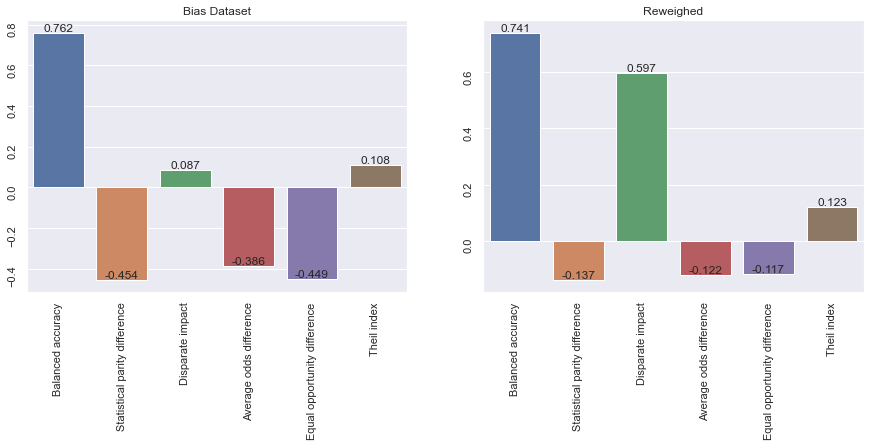

In [76]:
plot_metrics_comparison(df2_class, rw_df2_class, 'Bias Dataset', 'Reweighed')
plt.show()

## Modified Reweighing (Sampling)

Original dataset size: (30940,8)
Sampled dataset size: (30921,8)


Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


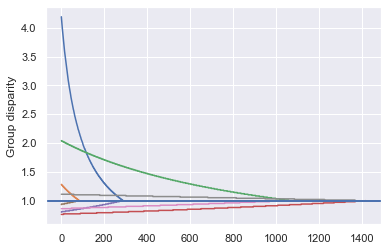

In [77]:
groups = [(df_2['sex']==0)&(df_2['race']==0),(df_2['sex']==1)&(df_2['race']==0),(df_2['sex']==0)&(df_2['race']==1),(df_2['sex']==1)&(df_2['race']==1)]
sampled2 = sample_dataset(
    df_2.copy(),
    groups,
    df_2['income'] == 1,
    df_2['income'] == 0,
    ['sex','race'],
    'income',
    round_level=2)
plt.show()

In [78]:
metrics = compute_dataset_fairness_metrics(sampled2, unprivileged_group, privileged_group)

Disparate Impact = 0.9871
Statistical Parity = -0.0032


Balanced accuracy: 0.7315
Statistical parity difference: -0.0157
Disparate impact: 0.9550
Average odds difference: -0.0044
Equal opportunity difference: 0.0157
Theil index: 0.1233


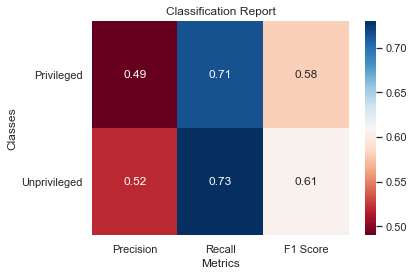

In [79]:
sampled_df2_class = classify(
    make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced', solver='liblinear')),
    sampled2, privileged_group, unprivileged_group)

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


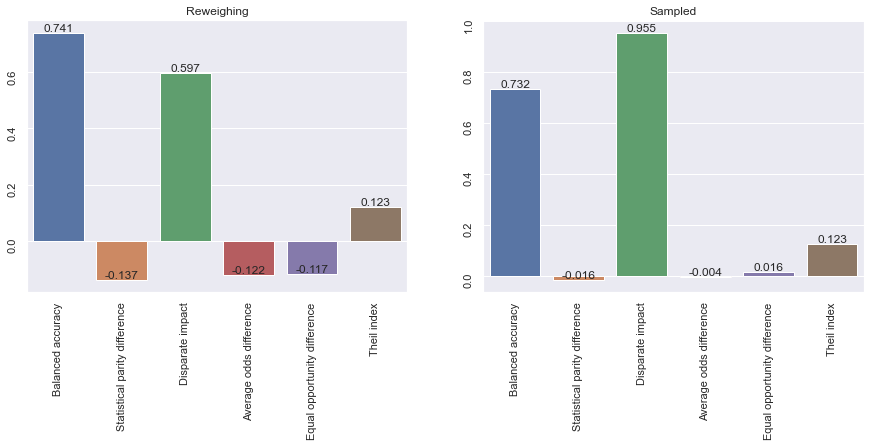

In [80]:
plot_metrics_comparison(rw_df2_class, sampled_df2_class, 'Reweighing', 'Sampled')
plt.show()

## Disparate Impact Remover

In [81]:
dir2 = df_2bin.copy()
scaler = MinMaxScaler(copy=False)
dir2.features = scaler.fit_transform(dir2.features)
df = dir2.convert_to_dataframe()[0]

In [82]:
probs = (
    df.value_counts(["sex", "race"], normalize=True).unstack().reset_index()
    .melt(id_vars='sex', value_vars=[0.0,1.0], var_name='race', value_name='probs'))

for sex,race,prob in probs.values:
    df.loc[(df['sex'] == sex) & (df['race'] == race), 'prob'] = prob

df.drop(df[['sex','race']], axis=1, inplace=True)

In [83]:
di = DisparateImpactRemover(sensitive_attribute='prob')
dir2 = BinaryLabelDataset(df = df, label_names=['income'], protected_attribute_names=['prob'])
dir2 = di.fit_transform(dir2)

In [84]:
df = dir2.convert_to_dataframe()[0]
df.loc[df['prob'].round(6) == 0.050259, 'prob'] = 0
df.loc[df['prob'].round(6) != 0, 'prob'] = 1

prob_priv_group = [{'prob': 1}]
prob_unpriv_group = [{'prob': 0}]
dir2 = BinaryLabelDataset(df = df, label_names=['income'], protected_attribute_names=['prob'])

In [85]:
metrics = compute_dataset_fairness_metrics(dir2, prob_unpriv_group, prob_priv_group)

Disparate Impact = 0.2294
Statistical Parity = -0.1944


Balanced accuracy: 0.7292
Statistical parity difference: -0.0500
Disparate impact: 0.8601
Average odds difference: 0.0533
Equal opportunity difference: 0.0687
Theil index: 0.1237


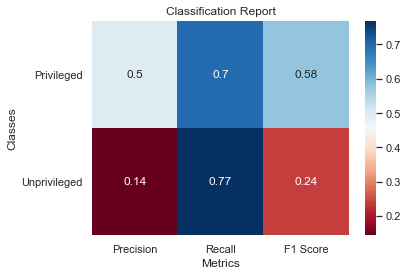

In [86]:
dir_df2_class = classify(
    make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced', solver='liblinear')),
    dir2, prob_priv_group, prob_unpriv_group, sensitive_attributes=['prob'])

## Algorithms comparison

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


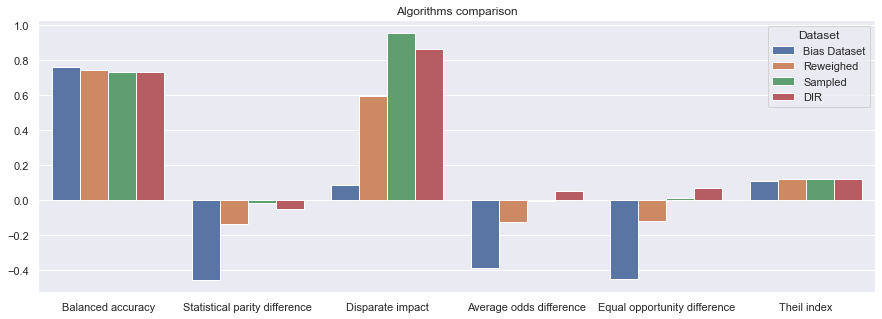

In [87]:
plot_syntesis(merge_datasets({
    'Bias Dataset': df2_class,
    'Reweighed': rw_df2_class,
    'Sampled': sampled_df2_class,
    'DIR': dir_df2_class
}), 'Algorithms comparison')
plt.show()